# Imagine that you work at a company that develops mobile games. A manager has come to you with a series of tasks to research several aspects of a mobile application:

- Firstly, they are interested in the retention rate. Write a function to calculate it.
- In addition, the company conducted A/B testing of promotional offer sets. Based on the available data, determine which set can be considered the best and on which metrics the correct decision should be based.
- Propose metrics to evaluate the results of the most recent thematic event in the game.

In [1]:
#download all neseccary data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from datetime import date
from dateutil.relativedelta import relativedelta

from scipy import stats 
from scipy.stats import bootstrap
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
#data 
reg = pd.read_csv('~/uploaded_docs/problem1-reg_data.csv',sep=';', on_bad_lines='warn')
auth = pd.read_csv('~/uploaded_docs/problem1-auth_data.csv',sep=';', on_bad_lines='warn')

In [3]:
reg

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [4]:
#translate from epoch time 
reg['date'] = pd.to_datetime(reg['reg_ts'],unit = 's',utc = True ).dt.date
auth['date'] = pd.to_datetime(auth['auth_ts'],unit = 's',utc = True).dt.date
reg['date'] = pd.to_datetime(reg['date'])
auth['date'] = pd.to_datetime(auth['date']) 

In [5]:
# little bit of eda 
print(reg.dtypes,\
      auth.dtypes,\
      
      reg.shape,\
      auth.shape,\
      
      reg.uid.isnull().sum(),\
      auth.uid.isnull().sum(),\
      
      reg['date'].describe(),\
      auth['date'].describe(),\
    
      reg['date'].mean(),\
      auth['date'].mean(),
      ) 

reg_ts             int64
uid                int64
date      datetime64[ns]
dtype: object auth_ts             int64
uid                 int64
date       datetime64[ns]
dtype: object (1000000, 3) (9601013, 3) 0 0 count                          1000000
mean     2019-01-24 00:12:37.209599232
min                1998-11-18 00:00:00
25%                2018-06-03 00:00:00
50%                2019-07-30 00:00:00
75%                2020-04-01 00:00:00
max                2020-09-23 00:00:00
Name: date, dtype: object count                          9601013
mean     2019-01-29 04:12:09.041572096
min                1998-11-18 00:00:00
25%                2018-06-07 00:00:00
50%                2019-07-31 00:00:00
75%                2020-04-02 00:00:00
max                2020-09-23 00:00:00
Name: date, dtype: object 2019-01-24 00:12:37.209599232 2019-01-29 04:12:09.041572096


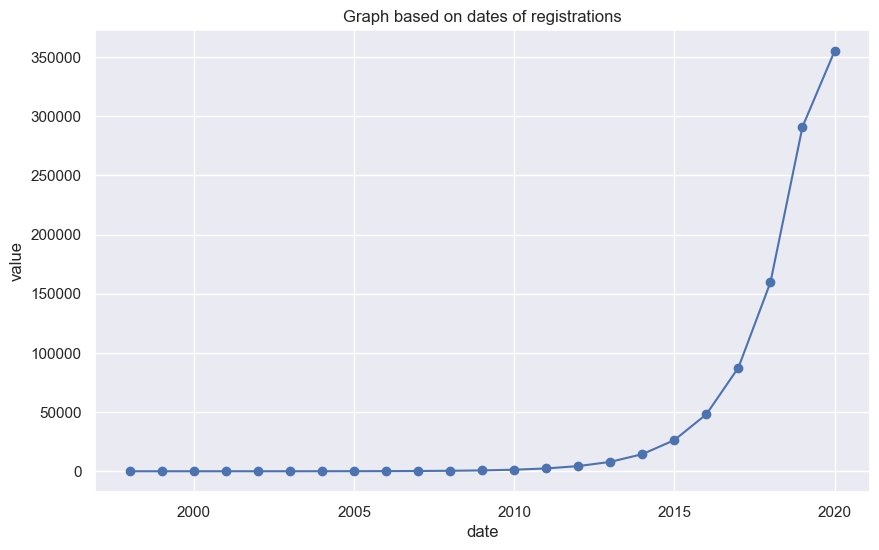

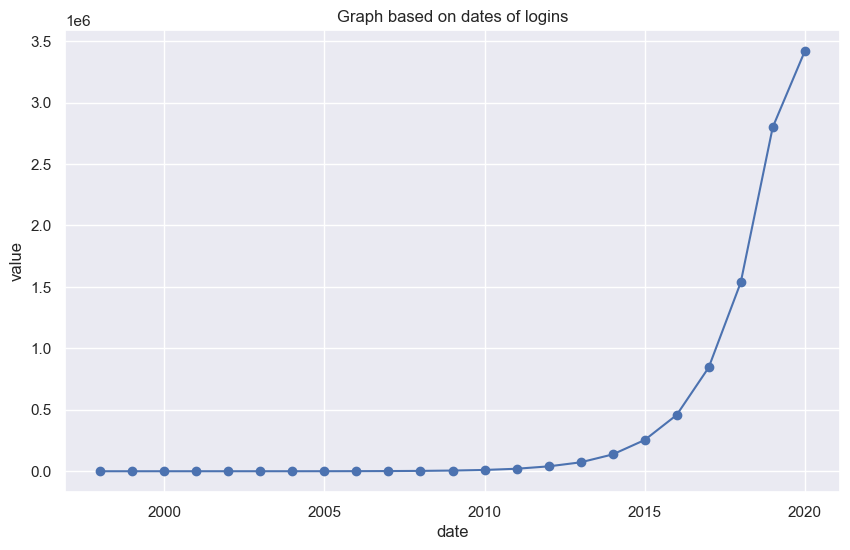

In [6]:
#let's see the structure of the data 
reg['year'] = (pd.to_datetime(reg['date']).dt.year)
years1 = reg.groupby('year').agg({'date':'count'})
auth['year'] = (pd.to_datetime(auth['date']).dt.year)
years2 = auth.groupby('year').agg({'date':'count'})

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.plot(years1, marker='o', linestyle='-')
plt.title('Graph based on dates of registrations')
plt.xlabel('date')
plt.ylabel('value')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years2, marker='o', linestyle='-')
plt.title('Graph based on dates of logins')
plt.xlabel('date')
plt.ylabel('value')
plt.grid(True)
plt.show()

# Step 1 

- Retention is one of the most important metrics in the company. Your task is to write a function that will calculate player retention (by days from the player's registration date).

In [7]:
# getting ready the data
df = auth.merge(reg, how = 'left', on = 'uid')
df = df.rename(columns = {'date_x':'login_date', 'date_y':'reg_date'})
df = df.drop(columns = ['reg_ts','auth_ts'])
df 

,uid,login_date,year_x,reg_date,year_y
0,1,1998-11-18,1998,1998-11-18,1998
1,2,1999-07-22,1999,1999-07-22,1999
2,2,1999-07-25,1999,1999-07-22,1999
3,2,1999-07-31,1999,1999-07-22,1999
4,2,1999-08-05,1999,1999-07-22,1999
...,...,...,...,...,...
9601008,1110618,2020-09-23,2020,2020-09-23,2020
9601009,1110619,2020-09-23,2020,2020-09-23,2020
9601010,1110620,2020-09-23,2020,2020-09-23,2020
9601011,1110621,2020-09-23,2020,2020-09-23,2020


In [8]:
df.dtypes

uid                    int64
login_date    datetime64[ns]
year_x                 int32
reg_date      datetime64[ns]
year_y                 int32
dtype: object

retention rate

In [35]:
def weekly_retention(dataframe, weeks_ret):
    '''
    The function returns retention tables with absolute and relative values.
    
        Parameters:
            dataframe (DataFrame) : dataframe 
            weeks_ret (int): number of weeks over which we want to analyze, assuming that 
            filtering will be performed from the end of the dataframe 
           
        Returns:
            retention_grouped (DataFrame): dataframe with absolute values
            retention_table_per (Dataframe): dataframe with relative values
            table with relative values with heatmap for easier understanding '''
    
    last_weeks = dataframe['reg_date'].max() - relativedelta(weeks = weeks_ret)
    dataframe  = dataframe.loc[dataframe['reg_date'] > last_weeks].copy()
    
    
    dataframe['reg_date']   = pd.to_datetime(dataframe['reg_date'])
    dataframe['login_date'] = pd.to_datetime(dataframe['login_date'])
    dataframe['log_index']  = dataframe['login_date'] - pd.to_timedelta(dataframe['login_date'].dt.dayofweek, unit='D')
    dataframe['reg_date']   = dataframe['reg_date'] - pd.to_timedelta(dataframe['reg_date'].dt.dayofweek, unit='D')
    dataframe['login_diff']  = ((dataframe['log_index'] - dataframe['reg_date']) / pd.Timedelta(days=7)).astype(int)


    df                      = dataframe[['uid','reg_date', 'login_diff']]
    df                      = df.drop_duplicates(subset = ['uid','reg_date','login_diff'])
    retention_grouped       = df.groupby(['reg_date','login_diff']).size().unstack()
    retention_grouped       = retention_grouped.rename(columns = {'uid':'customer_count'})
    retention_table_per     = retention_grouped.divide(retention_grouped.iloc[:,0], axis = 0).round(2) 
    retention_table_per.index = retention_table_per.index.strftime('%Y-%m')
    
    print('weekly retention table for {} weeks'.format(weeks_ret))
    print(retention_grouped)
    print('weekly percentile retention table for {} weeks'.format(weeks_ret))
    print(retention_table_per)
    
    
    fig,ax = plt.subplots(1,1,figsize = (16,10))
    sns.heatmap(retention_table_per, annot = True,vmin = 0,vmax = 0.25, fmt = '.0%', cbar = False, cmap = "YlGnBu")
    ax.set_xlabel('Cohort Index from last {} weeks'.format(weeks_ret))
    ax.set_ylabel('Cohort weeks')
    ax.xaxis.set_label_position('top')
    plt.show

weekly retention table for 6 weeks
login_diff        0       1       2       3       4      5      6
reg_date                                                         
2020-08-10   6163.0  1416.0  1242.0  1046.0   841.0  660.0  270.0
2020-08-17  10882.0  2586.0  2253.0  1896.0  1512.0  727.0    NaN
2020-08-24  11008.0  2491.0  2168.0  1775.0   850.0    NaN    NaN
2020-08-31  11136.0  2630.0  2268.0  1135.0     NaN    NaN    NaN
2020-09-07  11265.0  2620.0  1384.0     NaN     NaN    NaN    NaN
2020-09-14  11395.0  1461.0     NaN     NaN     NaN    NaN    NaN
2020-09-21   4327.0     NaN     NaN     NaN     NaN    NaN    NaN
weekly percentile retention table for 6 weeks
login_diff    0     1     2     3     4     5     6
reg_date                                           
2020-08     1.0  0.23  0.20  0.17  0.14  0.11  0.04
2020-08     1.0  0.24  0.21  0.17  0.14  0.07   NaN
2020-08     1.0  0.23  0.20  0.16  0.08   NaN   NaN
2020-08     1.0  0.24  0.20  0.10   NaN   NaN   NaN
2020-09     1

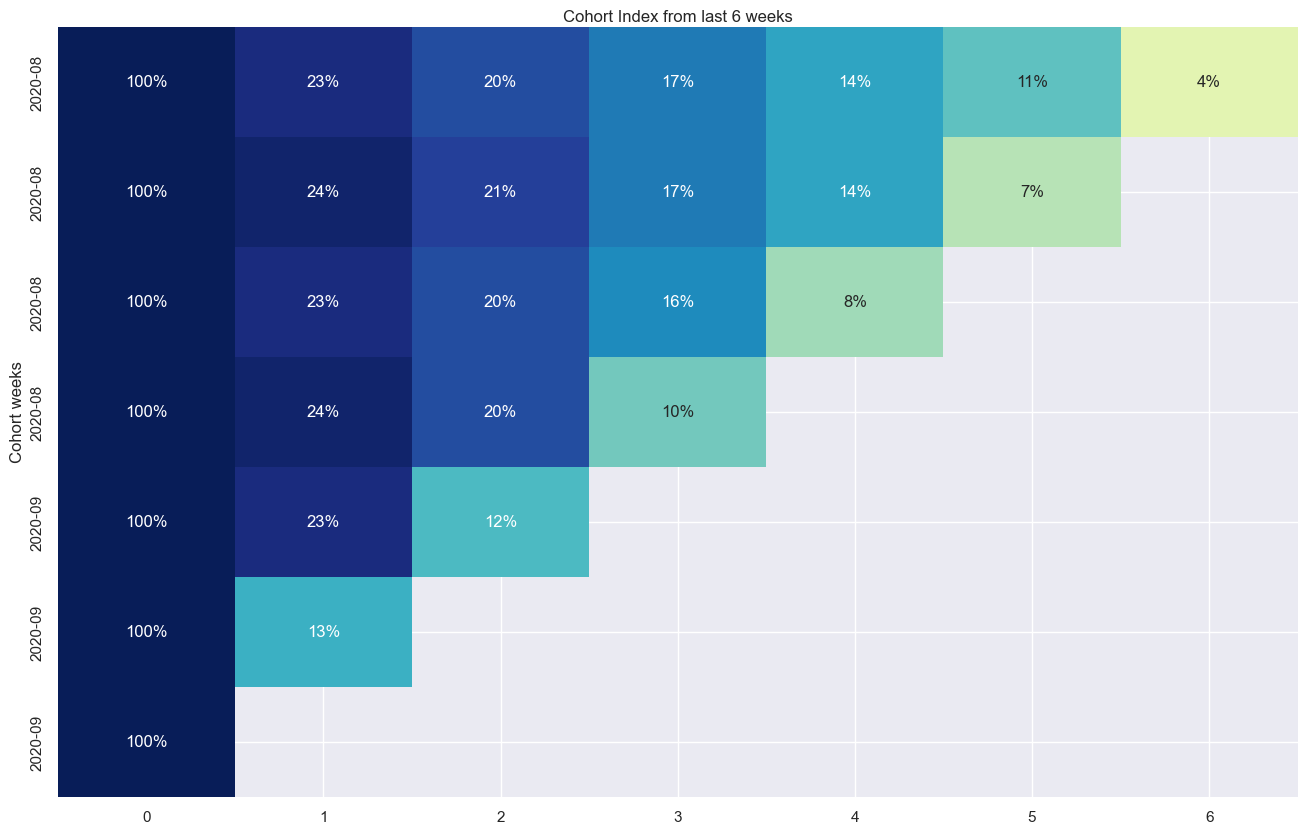

In [36]:
weekly_retention(df, 6)

In [11]:
# For some reason, in the last week, the retention rate dropped very low. Perhaps there were some technical 
# issues or events or the lack thereof in the application. 
# If you filter by game levels, you will see at which level the largest number of people drop off, and then you can 
# look more closely at the game and its settings to see what the player is experiencing. 
# Another option is to gather feedback.

# Step 2

There are results from an A/B test in which two groups of users were offered different sets of promotional offers. It is known that ARPU in the test group is 5% higher than in the control group. In the control group, 1928 out of 202,103 players were paying, while in the test group, 1805 out of 202,667 were paying.

- Which set of offers can be considered the best? What metrics should be analyzed to make the right decision and how?

In [96]:
#For a comprehensive answer, we need to understand which metric requires improvement, 
# and create a hypothesis that a certain action will impact a specific metric. According to the task, it is stated that ARPU 
# in the test group is higher than in the control group.
# Since I assume that the application model is freemium, the main metric for such applications is 
# likely conversion. However, since we are conducting testing and want to increase ARPU, the KEY metric 
# will be ARPU/ARPPU, while PROXY metrics are CONVERSION RATE, ACTIVE USERS, and RETENTION RATE.
#
#
# NULL HYPOTHESIS: There is no difference in the effect between players who received the test set of promotional offers
# and those who received the regular set of promotional offers.

In [14]:
#getting data ready
task_2 = pd.read_csv('~/uploaded_docs/Проект_1_Задание_2.csv',sep = ';')
task_2control = task_2.query('testgroup == "a"').copy()
task_2test = task_2.query('testgroup == "b"').copy()
print(task_2control.head())
print(task_2test.head())

    user_id  revenue testgroup
1         2        0         a
2         3        0         a
9        10        0         a
10       11        0         a
11       12        0         a
   user_id  revenue testgroup
0        1        0         b
3        4        0         b
4        5        0         b
5        6        0         b
6        7        0         b


In [15]:
print('control group: ' ,task_2control.nunique())
print(task_2control.shape)
print("test group: " ,task_2test.nunique())
print(task_2test.shape)

control group:  user_id      202103
revenue         269
testgroup         1
dtype: int64
(202103, 3)
test group:  user_id      202667
revenue        1209
testgroup         1
dtype: int64
(202667, 3)


In [16]:
print(task_2control.revenue.sum() / 202103)
print(task_2test.revenue.sum() / 202667)

25.413719736965806
26.75128659327863


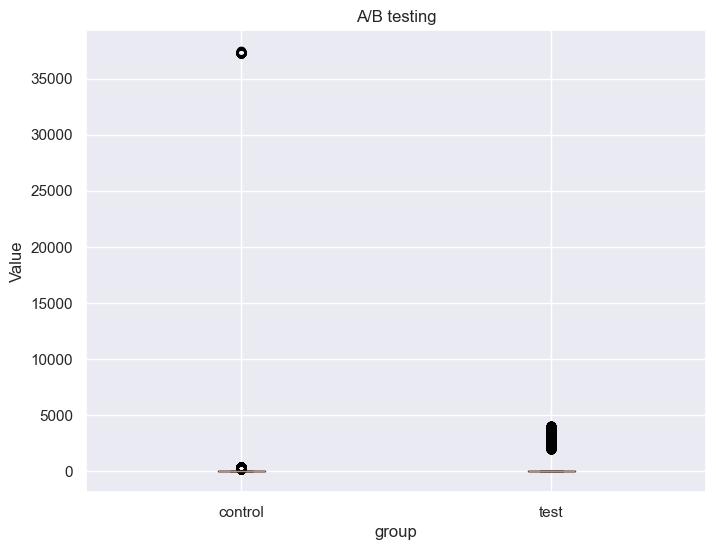

In [17]:
plt.figure(figsize=(8, 6))
plt.boxplot([task_2control['revenue'], task_2test['revenue']], labels=['control', 'test'])
plt.xlabel('group')
plt.ylabel('Value')
plt.title('A/B testing')


plt.grid(True)
plt.show()

In [18]:
# the two groups are not evenly divided, which casts doubt on the success of the split, we need to check if the split was done 
# a/a testing and what the result was, whether the a/a test was conducted fairly, i.e. whether the waiting times were similar, etc. 
# in the appendix, whether the result gave significant differences even then.

In [19]:
# conversion to paying customers
num_pay_users_a = task_2control.query('revenue > 0')['user_id'].nunique()
num_pay_users_b = task_2test.query('revenue > 0')['user_id'].nunique()
conv_a = (num_pay_users_a / task_2control.user_id.nunique()) * 100
conv_b = (num_pay_users_b / task_2test.user_id.nunique()) * 100
print(num_pay_users_a)
print(num_pay_users_b)
print(conv_a)
print(conv_b)

1928
1805
0.9539690157988748
0.8906235351586593


In [20]:
#revenue of two groups
print('control', task_2control.revenue.sum())
print('test', task_2test.revenue.sum())

control 5136189
test 5421603


In [21]:
#there is a difference between groups in conversion and average value, but we need to understand what are the PRACTICALLY SIGNIFICANT and 
# STATISTICALLY SIGNIFICANT differences
# We have to figure out which change is going to be beneficial.
# For example, let's say that for a company a change in the average of three rubles or more is practically significant 
# (costs will cover the gains from the change) when we get an average of about 28 or more. 
# I will choose 5% as the statistical level of significance as it is in my opinion the most optimal, but it can be changed depending on the request.
# change depending on the request.

ARPU/ARPPU metric analysis

To compare the averages in two groups, we need a t-test. 
In order to conduct a t-test, the samples must meet these requirements 
- Normality of the distribution of the data , but according to the t-test, if the sample size is large enough, the distribution of the mean will tend towards normality even if the data itself is not normal. This allows the t-test to be used for large samples.
- Homoscedasticity 
- Independence of observationsSample 
- size
- Representativeness of the sample.

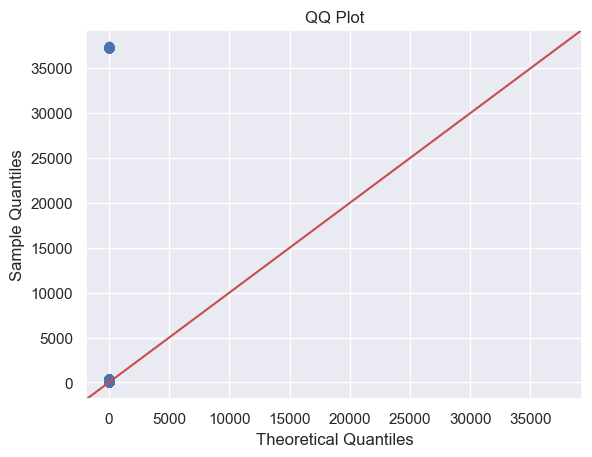

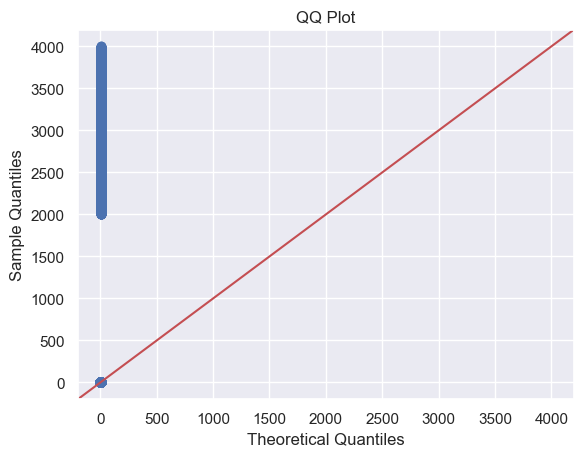

In [22]:
# lets see how are they arranged 
sm.qqplot(task_2control['revenue'], line='45')
plt.title('QQ Plot')
plt.show()


sm.qqplot(task_2test['revenue'], line='45')
plt.title('QQ Plot')
plt.show()

In [23]:
# data is not normally distributed

In [24]:
# logarithmize columns to smooth absolute values, making differences between two groups 
# more linear and easier to detect by statistical tests
task_2test['logs'] = np.log(task_2test['revenue'] + 1) 
task_2control['logs'] = np.log(task_2control['revenue'] + 1)

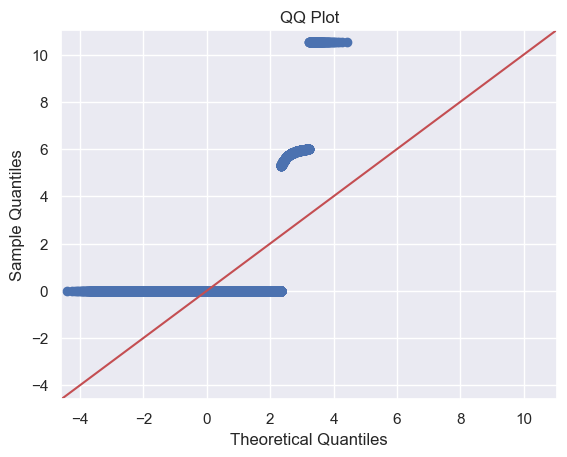

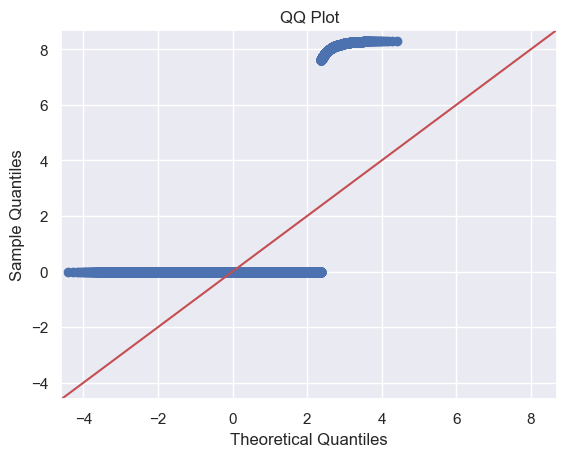

In [25]:
#lets see what happened
sm.qqplot(task_2control['logs'], line='45')
plt.title('QQ Plot')
plt.show()


sm.qqplot(task_2test['logs'], line='45')
plt.title('QQ Plot')
plt.show()

In [26]:
# perform Levene's test for equality of variance 
stat, p_value = stats.levene(task_2control['logs'], task_2test['logs'])

The samples are non-normally distributed, the variance of the samples is not equal, all observations are independent of each other, the sample size is larger than 30 observations (suitable for the t-test) and assuming that the representativeness of the sample meets the requirements, I use a modification of the t-test called Welch's t-test, which does not require equality of variance.

In [27]:
# test for differences in mean values between two groups among players
stats.ttest_ind(task_2control['logs'], task_2test['logs'], equal_var=False)

TtestResult(statistic=-6.514242689960279, pvalue=7.314671415006434e-11, df=385197.2518799914)

In [28]:
# test for differences in mean values between two groups among customers 
stats.ttest_ind(task_2control.query('revenue > 0')['logs'],task_2test.query('revenue > 0')['logs'],equal_var=False)

TtestResult(statistic=-71.81304605825281, pvalue=0.0, df=2037.9400440625348)

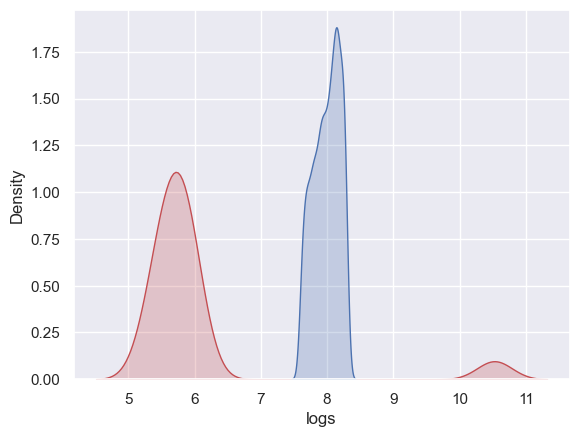

In [29]:
sns.kdeplot(task_2control.query('revenue > 0')['logs'], fill=True, color="r")
sns.kdeplot(task_2test.query('revenue > 0')['logs'], fill=True, color="b")
plt.show()

CONVERSION RATE metric analysis

For comparison of two categorical groups the chi square test and Fisher's test are used, since the groups are large and do not consist of zero values I will use the chi square test the use of which is required: 
- Comparable frequencies must be of approximately the same size
- Compared groups must be independent (that is, the units of observation in them are different, unlike linked groups analyzing “before-after” changes in the same units of observation before and after the intervention.




Samples are large and roughly equal, groups are independent - data fit the requirements

In [30]:
# chi square table, and group conversion # 
data = {'paid': [1928, 1805, 3733],
        'not_paid': [200175, 200862, 401037],
        'overall': [202103, 202664, 404770]}


chi_table = pd.DataFrame(data, index = ['control', 'test', 'overall'])


chi_table['conversion_rate'] = (chi_table['paid'] / chi_table['overall']) * 100
chi_table

,paid,not_paid,overall,conversion_rate
control,1928,200175,202103,0.953969
test,1805,200862,202664,0.890637
overall,3733,401037,404770,0.922252


In [31]:
# the first column contains players who bought the product on promotion 
# the second column contains players who did not buy the promotional product 
# first row control group 
# second row test group 
observed = np.array([[1928, 200175], [1805, 200862]])
observed

array([[  1928, 200175],
       [  1805, 200862]])

In [33]:
chi2, p_value, dof, expected = chi2_contingency(observed)

In [34]:
print(chi2, p_value, dof, expected)

4.374729521260405 0.03647561892312613 1 [[  1863.89924896 200239.10075104]
 [  1869.10075104 200797.89924896]]


# ANSWER 2.
- Based on the results of the t-test, I reject the hypothesis that there is no effect between players who received the test set of promotional offers and those who received the regular set of promotional offers. The test sample performed BETTER (in terms of ARPU/ARPPU) than the control sample. The statistic=-6.514242689960279 indicates that the mean in the first group is lower than the mean in the second group. The p_value=-7.415779070894375e-11 indicates that the differences between groups are statistically significant.
- According to the chi square results, p_value = 0.03647561892312613 which indicates that there are statistically significant differences in conversion between the test and control samples, and the test sample performed worse than the control sample.According to the results on the first task I see that almost half of the players dropped out. If the experiment took place from 2020-09-14 to 2020-09-21 then the conclusion is that the retention of the test group is very low
To make a decision, you have to be sure about .
1. Why the data has such large values (outliers) in the control sample
2. check the split system before the experiment.
3. how the test version affected the metrics related to engagement, how engaged players were after the purchase.
# Conclusion:
It is necessary to understand additional metrics, and looking at these metrics to refine the test version. Make some adjustments without affecting arpu/arppu if it's possible. But at the moment, based on the results of two tests, the control variant showed itself better, conversion is a little less, but arpu/arppu is noticeably higher. 

# ASSIGNMENT 3
Question:
In the Plants & Gardens game, there are themed events every month that are limited in time. In them, players can get unique items for the garden and characters, extra coins or bonuses. The rewards require completing a series of levels in a certain amount of time. What metrics can be used to evaluate the results of the most recently passed event? Suppose in another event, we have complicated the event mechanics so that for every unsuccessful attempt to complete a level, the player will roll back a few levels. Would the set of outcome evaluation metrics change? If so, how?

# ANSWER 3:
For the first event, we will need:
   - DAU is the number of active users during the day.
   - Session Frequency - the frequency of individual game sessions.
   - Duration - duration of game sessions
   - Level Conversion - percentage of players who have reached a certain level in relation to the total number of players.
   - Churn Rate - percentage of users leaving the game
   - Retention - percentage of returning users
   - ARPU - average revenue per user.
\
\
For the second event:
   - Retention Rate for Specific Levels - measures the percentage of users who successfully complete a specific level and then return to retain it for another time.
   - level and then returned to complete it again within a certain amount of time.
   - Average Time to Complete Level - The average time it takes users to complete a particular level. 
   - Level Difficulty - the difficulty of a particular level in the game.
   - User Satisfaction Level - the satisfaction of users from a certain level.
   - Number of Attempts to Complete Level - the number of attempts users make to complete a particular level. 
   - Churn Rate - The percentage of users who leave.
   -  Retention - percentage of returning users
   -  ARPU - Average Revenue Per User